<div style="background-color:#e8f4fd; padding:1em; border-radius:6px;">
<b>Notebook Disclaimer</b><br><br>
This notebook is part of the supporting material for the paper:<br>
<i>Modeling soil organic carbon changes using signal-to-noise analysis: a case study using European soil survey datasets.</i><br><br>
The figure and accompanying text are designed to be self-explanatory — you shouldn’t need to dive into the code to get the point :)<br>
But if you are curious about the implementation details, feel free to check the code blocks, too.
</div>

# Model Calibration

This notebook outlines the process of calibrating the $RF_{c}$ model, including **feature selection** and **hyperparameter tuning**. The other two notebooks, **07b** and **07c**, follow the same structure and processing pipeline as this one, but they are applied to different target variables — **$\delta$** and **$\beta$**, respectively.

## Feature Selection

We use the **Repeated Subsampling-Based Cumulative Feature Importance (RSCFI)** method — a process similar to recursive feature elimination with cross-validation.  
It iteratively removes features with low cumulative importance scores, keeping only the most relevant predictors while balancing model performance and computational efficiency.

This method has two main phases, implemented in the functions **`cfi_calc()`** and **`rscfi()`**, which work together to identify and retain the most useful features using a Random Forest model.


In [1]:
##################
# basic settings #
##################

# param
version = 'v20250521'
prop = 'soc'
tgt = 'soc_log1p'
space = 'normal'
output_folder = './metric/'

# data
import pandas as pd
import numpy as np
cal = pd.read_parquet(f'./material/pnt_cal_{version}.pq')
print('calibration data:', cal.shape)


# covariate
covs = cal.columns[13::].tolist()
print(len(covs))
covs.remove('type')
covs.remove('tile_id')
covs.remove('soc_log1p')

drop_cov = []
for ii in covs:
    if 'theilslopes' in ii:
        print(ii)
        drop_cov.append(ii)
        
    if 'evi' in ii: #only bimonthly
        print(ii)
        drop_cov.append(ii)
        
for ii in drop_cov:
    covs.remove(ii)
    
print(len(covs))

calibration data: (6000, 421)
408
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg.3035_v20231127
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg.3035_v20231127
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY1101_YYYY1231_eu_epsg.3035_v20231127
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0701_YYYY0831_eu_epsg.3035_v20231127
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0501_YYYY0630_eu_epsg.3035_v20231127
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY0228_eu_epsg.3035_v20231127
ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218
ndti.min.slopes_glad.landsat.ard2.seasconv.yearly.min.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218
bsf_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218
ndwi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218
395


### `cfi_calc()` — Calculate Feature Importance (CFI)

This function identifies which features are most important for predicting the target variable.  
It cleans the data, then trains a Random Forest model 20 times using different random subsets.  
Each run records how much each feature contributes to the prediction, and the results are averaged to get stable importance scores.

The output is a CSV file listing each feature and its average importance.  
Higher scores mean stronger influence on the target.

**In short:** `cfi_calc()` produces a ranked list of features by importance.

In [4]:
###################
# CFI calculation #
###################

from model_fit import cfi_calc
cal = cal.dropna(subset = covs+[tgt])
cfi = cfi_calc(cal, tgt, prop, space, output_folder, version, covs) # produce

start bootstrap on different subset...
[08:50:22] 0 iteration, training size: 4200
[08:50:26] 1 iteration, training size: 4200
[08:50:29] 2 iteration, training size: 4200
[08:50:34] 3 iteration, training size: 4200
[08:50:37] 4 iteration, training size: 4200
[08:50:41] 5 iteration, training size: 4200
[08:50:45] 6 iteration, training size: 4200
[08:50:49] 7 iteration, training size: 4200
[08:50:53] 8 iteration, training size: 4200
[08:50:58] 9 iteration, training size: 4200
[08:51:01] 10 iteration, training size: 4200
[08:51:05] 11 iteration, training size: 4200
[08:51:09] 12 iteration, training size: 4200
[08:51:13] 13 iteration, training size: 4200
[08:51:17] 14 iteration, training size: 4200
[08:51:20] 15 iteration, training size: 4200
[08:51:24] 16 iteration, training size: 4200
[08:51:28] 17 iteration, training size: 4200
[08:51:32] 18 iteration, training size: 4200
[08:51:35] 19 iteration, training size: 4200


### `rscfi()` — Recursive Selection Based on Feature Importance

After calculating feature importance, `rscfi()` determines which features to keep.  
It progressively raises the importance threshold, removing weaker features and retraining the model at each step.  
For every threshold, it evaluates performance using metrics such as RMSE, CCC, and bias.

By comparing performance across thresholds, it finds the best balance between accuracy and simplicity — keeping only the features that matter most.  
The selected features are saved to a text file, and a PDF plot shows how model performance changes as features are removed.

**In short:** `rscfi()` selects the optimal subset of features for a strong, efficient model.

#### Plot analysis

The plot below illustrates the **feature elimination process** performed by the RSCFI algorithm.  
At each step, features with lower importance scores are removed, reducing the total number of features while model performance is re-evaluated.

From the plot, we can see that about **200 features with very low importance** are eliminated in the first step, which makes the process highly efficient.  
Removing features with **CFI values below 0.005** has little effect on model performance.  
However, once features with **CFI above 0.005** begin to be removed (fewer than 50 such features remain), the model’s performance drops sharply.


[08:51:39] processing 0.0 ...
[08:51:58] processing 0.0002 ...
[08:52:15] processing 0.0004 ...
[08:52:33] processing 0.0006000000000000001 ...
[08:52:50] processing 0.0008 ...
[08:53:07] processing 0.001 ...
[08:53:23] processing 0.0012000000000000001 ...
[08:53:39] processing 0.0014 ...
[08:53:54] processing 0.0016 ...
[08:54:08] processing 0.0018000000000000002 ...
[08:54:20] processing 0.002 ...
[08:54:32] processing 0.0022 ...
[08:54:43] processing 0.0024000000000000002 ...
[08:54:53] processing 0.0026000000000000003 ...
[08:55:02] processing 0.0028 ...
[08:55:11] processing 0.003 ...
[08:55:18] processing 0.0032 ...
[08:55:24] processing 0.0034000000000000002 ...
[08:55:30] processing 0.0036000000000000003 ...
[08:55:35] processing 0.0038 ...
[08:55:40] processing 0.004 ...
[08:55:43] processing 0.004200000000000001 ...
[08:55:47] processing 0.0044 ...
[08:55:50] processing 0.0046 ...
[08:55:53] processing 0.0048000000000000004 ...
[08:55:55] processing 0.005 ...
[08:55:58] proce

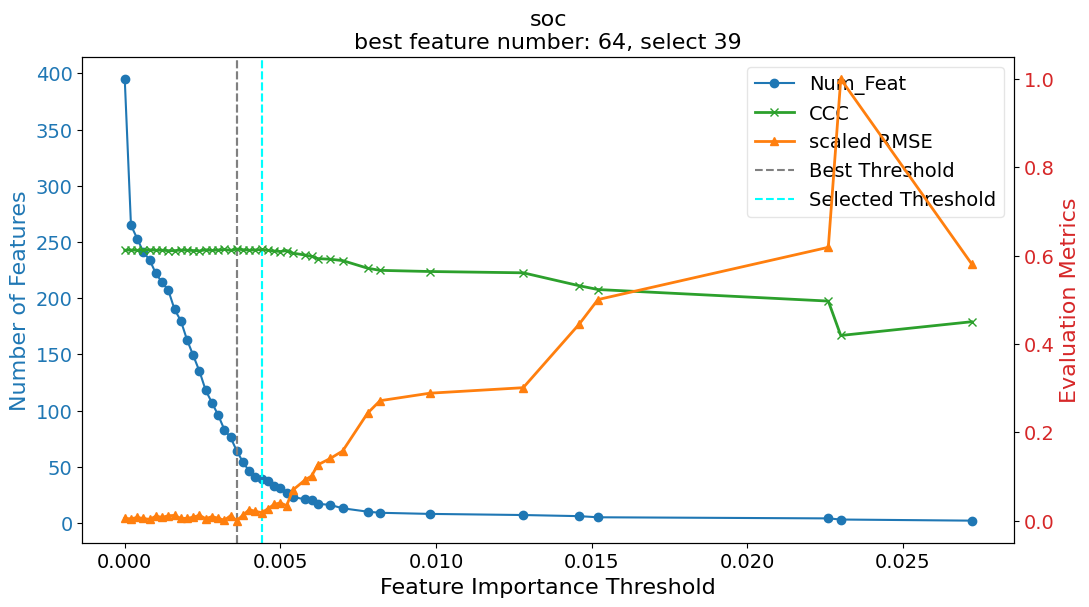

In [5]:
#####################
# RSCFI elimination #
#####################
from model_fit import rscfi
cov = rscfi(cal, tgt, prop, space, output_folder, version, covs, cfi, [10,50], step_size=0.0002) # produce

In [6]:
###############################
# Hyper-parameter fine tuning #
###############################

from model_fit import parameter_fine_tuning, read_features
models, model_names = parameter_fine_tuning(cal, cov, tgt, prop, './model/', version, None)

[08:56:17] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 74
max_resources_: 6000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 74
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 222
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 666
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 1998
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 5994
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [7]:
##################
# Save the model #
##################

import joblib
model = joblib.load('/home/xuemeng/work_xuemeng/trend-with-uncertainty/model/model_rf.soc_ccc_v20250521.joblib')
len(model.feature_names_in_)

39

In [8]:
model.feature_names_in_

array(['fapar_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231218',
       'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
       'red_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127',
       'CHELSA_ai_1981-2010_V.2.1',
       'pft.grass.nat_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616',
       'green_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127',
       'CHELSA_gdgfgd10_1981-2010_V.2.1',
       'CHELSA_cmi_mean_1981-2010_V.2.1',
       'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127',
       'clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm_YYYY_v2.1',
       'wv_mcd19a2v061.seasconv.sd.yearly_p75_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619',
       'CHELSA_pr_09_1981-2010_V.2.1',
       'soil.moisture_s1.clms.qr.4.p0.5_m_1km_20140101_20241231_eu_epsg3035_v